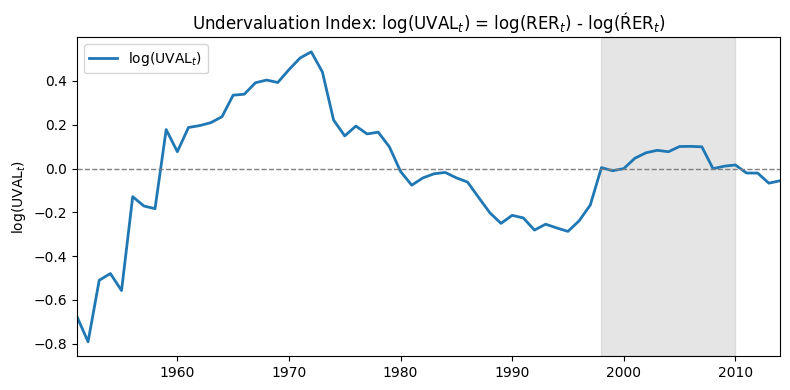

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# === 1. Load and prepare data ===
df = pd.read_stata("../data/raw/pwt1001.dta")
tw = df.query("countrycode == 'TWN' & year.between(1951, 2014)").copy()
tw.loc[tw["pl_gdpo"] == 0, "pl_gdpo"] = np.nan

# === 2. Compute log(RER) and log(GDP per capita) ===
tw["log_rer"] = -np.log(tw["pl_gdpo"])  # or log(xr / ppp)
tw["log_rgdpo_pc"] = np.log(tw["rgdpo"] / tw["pop"])

# Drop missing values
tw = tw[np.isfinite(tw[["log_rer", "log_rgdpo_pc"]]).all(axis=1)].copy()

# === 3. Fit regression & predict log(RER) ===
X = sm.add_constant(tw["log_rgdpo_pc"])
y = tw["log_rer"]
ols = sm.OLS(y, X).fit(cov_type="HAC", cov_kwds={"maxlags": 1})

tw["log_rer_hat"] = ols.predict(X)  # log(ŔER_t)
tw["log_uval"] = tw["log_rer"] - tw["log_rer_hat"]

# === 4. Plot: Rodrik undervaluation index ===
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(tw["year"], tw["log_uval"], label="log(UVAL$_t$)", linewidth=2)
ax.axhline(0, linestyle="--", color="gray", linewidth=1)
ax.axvspan(1998, 2010, color="gray", alpha=0.2)
ax.set_title("Undervaluation Index: log(UVAL$_t$) = log(RER$_t$) - log(ŔER$_t$)", fontsize=12)
ax.set_ylabel("log(UVAL$_t$)")
ax.set_xlim(1951, 2014)
ax.legend()
plt.tight_layout()
plt.show()
